In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb


In [2]:
df = pd.read_csv(r'C:\Users\jaraneses\OneDrive - 2X LLC\Codes\Portfolio Projects_storage\Day 17 - Car Price Prediction\car data.csv')

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.shape

(301, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [6]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [7]:
df.Owner.value_counts()

Owner
0    290
1     10
3      1
Name: count, dtype: int64

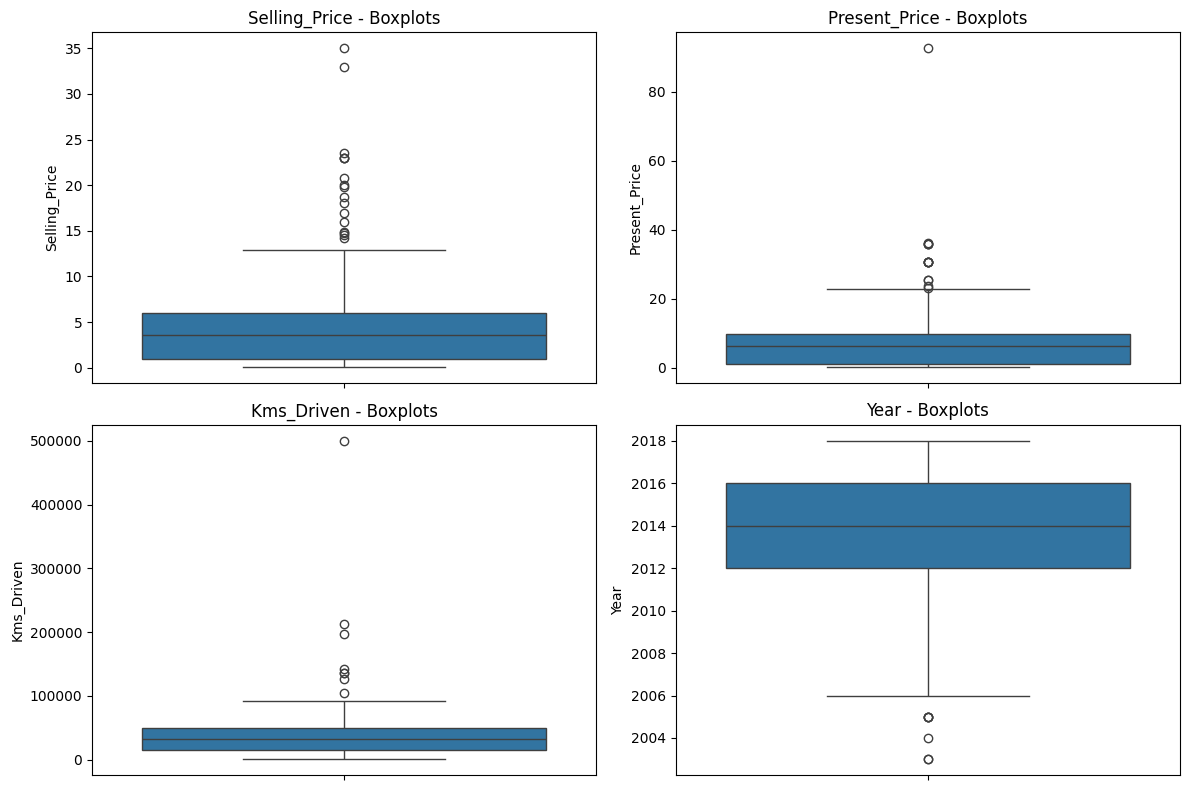

In [8]:
fig, axes = plt.subplots(2,2, figsize = (12, 8))
numerical_cols = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Year']

for i, col in enumerate(numerical_cols):
    ax = axes[i//2, i%2]
    sns.boxplot(data = df, y = col, ax = ax)
    ax.set_title(f'{col} - Boxplots')

plt.tight_layout()
plt.show()

In [9]:
extreme_outliers = df[
    (df['Present_Price'] > 50) |
    (df['Selling_Price'] > 30) |
    (df['Kms_Driven']> 300000) |
    (df['Year'] < 2006)
]

print(f'Outliers to investigate: {len(extreme_outliers)}')
print(extreme_outliers[['Car_Name', 'Year',	'Selling_Price', 'Present_Price', 'Kms_Driven', 'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']])

Outliers to investigate: 10
                Car_Name  Year  Selling_Price  Present_Price  Kms_Driven  \
37                   800  2003           0.35           2.28      127000   
39                   sx4  2003           2.25           7.98       62000   
54                innova  2005           2.75          10.21       90000   
64              fortuner  2017          33.00          36.23        6000   
77               corolla  2004           1.50          12.35      135154   
84                innova  2005           3.49          13.46      197176   
86          land cruiser  2010          35.00          92.60       78000   
92                innova  2005           3.51          13.70       75000   
189  Hero Super Splendor  2005           0.20           0.57       55000   
196            Activa 3g  2008           0.17           0.52      500000   

    Fuel_Type Seller_Type Transmission  Owner  
37     Petrol  Individual       Manual      0  
39     Petrol      Dealer       Manual 

In [10]:
# 196 (high mileage for scooter), outliers for the others seems reasonable

df = df.drop(196)

In [11]:
df[df['Car_Name'] == 'Activa']

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner


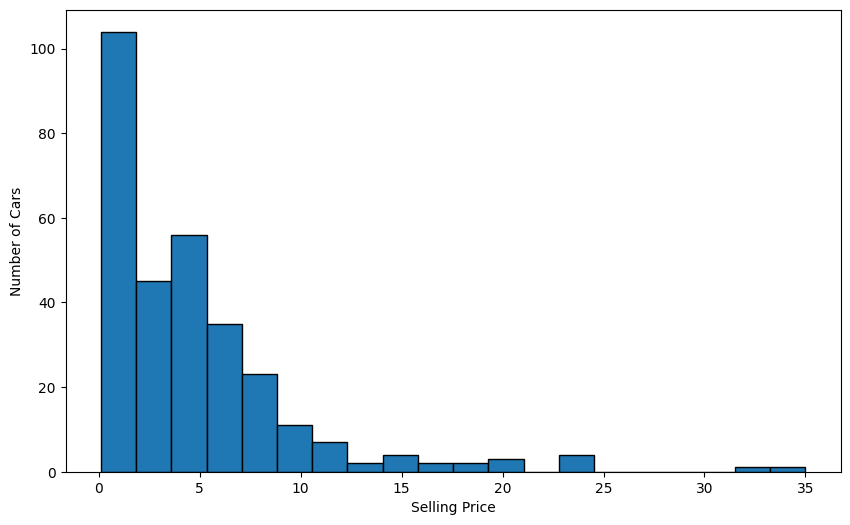

In [12]:
plt.figure(figsize= (10, 6))
plt.hist(df['Selling_Price'], bins = 20, edgecolor = 'black')
plt.xlabel('Selling Price')
plt.ylabel('Number of Cars')
plt.show()

# Right skewed, might need log transformation

In [13]:
print('Average Selling Price by Fuel Type:')
print(df.groupby('Fuel_Type')['Selling_Price'].agg(['mean', 'median', 'count']))

# Diesel so expensive

Average Selling Price by Fuel Type:
                mean  median  count
Fuel_Type                          
CNG         3.100000   3.100      2
Diesel     10.278500   7.750     60
Petrol      3.277185   2.675    238


In [14]:
price_brackets = [0, 2, 5, 10, 20, float('inf')]
labels = ['Budget (<2)', 'Economy (2-5)', 'Mid (5-10)', 'Premium (10-20)', 'Luxury (>20)']
df['Price_Range'] = pd.cut(df['Present_Price'], bins=price_brackets, labels=labels)
print(df['Price_Range'].value_counts())

Price_Range
Mid (5-10)         109
Budget (<2)         97
Premium (10-20)     47
Economy (2-5)       28
Luxury (>20)        19
Name: count, dtype: int64


In [15]:
# Car Age
df['Car_Age'] = 2025 - df['Year']

In [16]:
# Usage intensity per year
df['Kms_Per_Year'] = df['Kms_Driven'] / df['Car_Age']
df['High_Mileage'] = (df['Kms_Driven'] > 100000).astype(int)
df['Low_Mileage'] = (df['Kms_Driven'] > 30000).astype(int)

In [17]:
# Budget Car < 15
df['Is_Premium'] = (df['Present_Price'] > 15).astype(int)
df['Is_Luxury'] = (df['Present_Price'] > 25).astype(int)


In [18]:
# Car not old and new > 3 < 10
df['Is_New'] = (df['Car_Age'] < 3).astype(int)
df['Is_Old'] = (df['Car_Age'] > 10).astype(int)

In [19]:
# (Petrol = 2, Diesel = 1, CNG = 0)
le_fuel = LabelEncoder()
df['Fuel_Encoded'] = le_fuel.fit_transform(df['Fuel_Type'])

# (Dealer = 0, Individual = 1)
le_seller = LabelEncoder()  
df['Seller_Encoded'] = le_seller.fit_transform(df['Seller_Type'])

# (Manual = 1, Automatic = 0)
le_trans = LabelEncoder()
df['Transmission_Encoded'] = le_trans.fit_transform(df['Transmission'])

In [20]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Price_Range,...,Kms_Per_Year,High_Mileage,Low_Mileage,Is_Premium,Is_Luxury,Is_New,Is_Old,Fuel_Encoded,Seller_Encoded,Transmission_Encoded
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,Mid (5-10),...,2454.545455,0,0,0,0,0,1,2,0,1
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,Mid (5-10),...,3583.333333,0,1,0,0,0,1,1,0,1
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,Mid (5-10),...,862.500000,0,0,0,0,0,0,2,0,1
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,Economy (2-5),...,371.428571,0,0,0,0,0,1,2,0,1
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,Mid (5-10),...,3859.090909,0,1,0,0,0,1,1,0,1


In [21]:
columns_to_drop = ['Year', 'Fuel_Type', 'Seller_Type', 'Transmission', 'Price_Range', 'Car_Name', 'Selling_Price']
X = df.drop(columns = columns_to_drop)
y = np.log1p(df['Selling_Price'])

In [22]:
X

,Present_Price,Kms_Driven,Owner,Car_Age,Kms_Per_Year,High_Mileage,Low_Mileage,Is_Premium,Is_Luxury,Is_New,Is_Old,Fuel_Encoded,Seller_Encoded,Transmission_Encoded
0,5.59,27000,0,11,2454.545455,0,0,0,0,0,1,2,0,1
1,9.54,43000,0,12,3583.333333,0,1,0,0,0,1,1,0,1
2,9.85,6900,0,8,862.500000,0,0,0,0,0,0,2,0,1
3,4.15,5200,0,14,371.428571,0,0,0,0,0,1,2,0,1
4,6.87,42450,0,11,3859.090909,0,1,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,11.60,33988,0,9,3776.444444,0,1,0,0,0,0,1,0,1
297,5.90,60000,0,10,6000.000000,0,1,0,0,0,0,2,0,1
298,11.00,87934,0,16,5495.875000,0,1,0,0,0,1,2,0,1
299,12.50,9000,0,8,1125.000000,0,0,0,0,0,0,1,0,1


(array([20., 35., 19., 20.,  7.,  7., 12., 24., 22., 37., 29., 22., 16.,
        10.,  3.,  5.,  5.,  5.,  0.,  2.]),
 array([0.09531018, 0.26972062, 0.44413106, 0.61854149, 0.79295193,
        0.96736237, 1.14177281, 1.31618325, 1.49059368, 1.66500412,
        1.83941456, 2.013825  , 2.18823543, 2.36264587, 2.53705631,
        2.71146675, 2.88587719, 3.06028762, 3.23469806, 3.4091085 ,
        3.58351894]),
 <BarContainer object of 20 artists>)

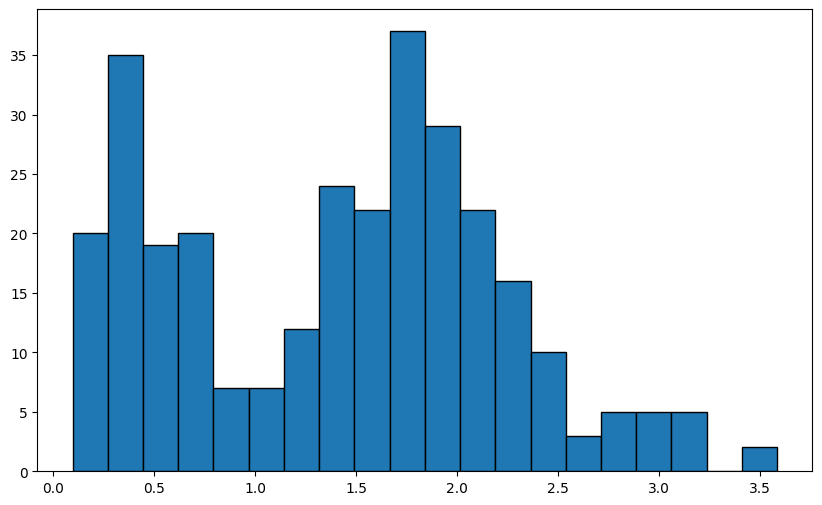

In [23]:
plt.figure(figsize= (10, 6))
plt.hist(y, bins = 20, edgecolor = 'black')

In [24]:
X.head()

,Present_Price,Kms_Driven,Owner,Car_Age,Kms_Per_Year,High_Mileage,Low_Mileage,Is_Premium,Is_Luxury,Is_New,Is_Old,Fuel_Encoded,Seller_Encoded,Transmission_Encoded
0,5.59,27000,0,11,2454.545455,0,0,0,0,0,1,2,0,1
1,9.54,43000,0,12,3583.333333,0,1,0,0,0,1,1,0,1
2,9.85,6900,0,8,862.500000,0,0,0,0,0,0,2,0,1
3,4.15,5200,0,14,371.428571,0,0,0,0,0,1,2,0,1
4,6.87,42450,0,11,3859.090909,0,1,0,0,0,1,1,0,1


In [25]:
print(X.shape)
print(y.shape)

(300, 14)
(300,)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 2)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
X_train_scaled

array([[ 1.63793466, -0.87622832, -0.16351749, ...,  0.50050075,
        -0.72709176, -2.50454133],
       [-0.76859219, -0.28434494, -0.16351749, ...,  0.50050075,
         1.37534224,  0.3992747 ],
       [-0.09866715, -0.8215161 , -0.16351749, ...,  0.50050075,
        -0.72709176,  0.3992747 ],
       ...,
       [ 1.14578908,  0.78848068, -0.16351749, ...,  0.50050075,
        -0.72709176,  0.3992747 ],
       [ 0.29808458,  0.30753844, -0.16351749, ..., -1.90190285,
        -0.72709176,  0.3992747 ],
       [-0.79244066, -0.83923561, -0.16351749, ...,  0.50050075,
         1.37534224,  0.3992747 ]], shape=(240, 14))

In [29]:
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge' : {
        'model' : Ridge(random_state= 2),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'Lasso': {
        'model': Lasso(random_state= 2),
        'params':{
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'Random Forest':{
        'model': RandomForestRegressor(random_state= 2),
        'params':{
            'max_depth': [10, 15, 20],
            'min_samples_split': [20,50],
            'n_estimators': [50, 100]
        }
    },
    'XGBRegressor' : {
        'model': xgb.XGBRegressor(random_state = 2),
        'params': {
            'max_depth' : [3, 5, 6],
            'learning_rate': [0.1, 0.2],
            'n_estimators' : [50, 100]
        }
    }
}

In [30]:
results = {}

for name, config in models.items():
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv = 5,
        scoring = 'neg_mean_absolute_error',
        n_jobs = -1
    )

    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_

    train_pred = best_model.predict(X_train_scaled)
    test_pred = best_model.predict(X_test_scaled)

    results[name] = {
        'best_params': grid_search.best_estimator_,
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'train_mae': mean_absolute_error(y_train, train_pred),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'test_rmse': np.sqrt(mean_absolute_error(y_test, test_pred))
    }

In [31]:
summary_data = []

for name, result in results.items():
    summary_data.append({
        'Model': name,
        'Train MAE': result['train_mae'],
        'Test MAE': result['test_mae'],
        'Train RMSE' : result['train_rmse'],
        'Test RMSE': result['test_rmse'],
        'Train R2': result['train_r2'],
        'Test R2' : result['test_r2']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)
print(summary_df.to_string(index = False))

           Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  Test R2
LinearRegression     0.1651    0.1826      0.2301     0.4273    0.9207   0.8810
           Ridge     0.1688    0.1916      0.2321     0.4377    0.9193   0.8723
           Lasso     0.2312    0.2290      0.2924     0.4786    0.8719   0.8605
   Random Forest     0.0952    0.1098      0.1388     0.3313    0.9712   0.9512
    XGBRegressor     0.0436    0.0752      0.0555     0.2742    0.9954   0.9794


In [37]:
import joblib

def save_model_pipeline():
    joblib.dump(le_fuel, 'fuel_encoder.pkl')
    joblib.dump(le_seller, 'seller_encoder.pkl')
    joblib.dump(le_trans, 'transmission_encoder.pkl')
    joblib.dump(scaler, 'standard_scaler.pkl')

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, 'car_price_model.pkl')

save_model_pipeline()

In [38]:
def predict_car_price(kms_driven, owner, car_age, fuel_type, seller_type, transmission, present_price): 
    try:
        le_fuel = joblib.load('fuel_encoder.pkl')
        le_seller = joblib.load('seller_encoder.pkl')
        le_trans = joblib.load('transmission_encoder.pkl')
        scaler = joblib.load('standard_scaler.pkl')
        model = joblib.load('car_price_model.pkl')

        kms_per_year = kms_driven / car_age if car_age > 0 else 0
        high_mileage = 1 if kms_driven > 100000 else 0
        low_mileage = 1 if kms_driven > 30000 else 0
        is_premium = 1 if present_price > 15 else 0
        is_luxury = 1 if present_price > 25 else 0
        is_new = 1 if car_age < 3 else 0
        is_old = 1 if car_age > 10 else 0

        fuel_encoded = le_fuel.transform([fuel_type])[0]
        seller_encoded = le_seller.transform([seller_type])[0]
        transmission_encoded = le_trans.transform([transmission])[0]

        features = [[present_price, kms_driven, owner, car_age, kms_per_year, 
                    high_mileage, low_mileage, is_premium, is_luxury, is_new, is_old, 
                    fuel_encoded, seller_encoded, transmission_encoded]]
        
        features_scaled = scaler.transform(features)

        log_price = model.predict(features_scaled)[0]
        actual_price = np.expm1(log_price)

        return round(actual_price, 2)

    except Exception as e:
        return f"Error in prediction: {str(e)}"

In [47]:
predicted_price = predict_car_price(
    kms_driven=45000,
    owner=0,
    car_age=11,
    fuel_type='Diesel',
    seller_type='Dealer',
    transmission='Manual',
    present_price=6.95
)

print(f"Predicted price:{predicted_price}")

Predicted price:4.440000057220459


c:\Users\jaraneses\OneDrive - 2X LLC\Codes\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [46]:
df.loc[65, ['Present_Price', 'Kms_Driven', 'Owner', 'Car_Age', 'Kms_Per_Year', 
           'High_Mileage', 'Low_Mileage', 'Is_Premium', 'Is_Luxury', 'Is_New', 'Is_Old', 
           'Fuel_Encoded', 'Seller_Encoded', 'Transmission_Encoded', 'Selling_Price']]

Present_Price                  6.95
Kms_Driven                    45000
Owner                             0
Car_Age                          11
Kms_Per_Year            4090.909091
High_Mileage                      0
Low_Mileage                       1
Is_Premium                        0
Is_Luxury                         0
Is_New                            0
Is_Old                            1
Fuel_Encoded                      1
Seller_Encoded                    0
Transmission_Encoded              1
Selling_Price                  4.75
Name: 65, dtype: object